In [1]:
# Supress seaborn FutureWarning (need old version for statannotations)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from statannotations.Annotator import Annotator

Change seaborn styling.

In [2]:
sns.set_theme(
    style='ticks',
    context='paper',
    rc={"axes.spines.right": False, "axes.spines.top": False},
    font_scale=1.5,
)
np.random.seed(98)

POINT_SIZE = 6
POINT_COLOR = '#454545'

Read in count data.

In [3]:
file_sample_names = ['liquid', 'semisolid', 'large_plate', 'small_plate', 'bead']
names_dict = {'liquid': 'liquid', 'semisolid': 'semisolid', 'small_plate': 'high-density spread', 'bead': 'bead spread', 'large_plate': 'low-density spread'}
sample_names = [names_dict[name] for name in file_sample_names]
counts = []

for sample in file_sample_names:
    for replicate in range(1, 5):
        with open(f'../data/counts/N80_{sample}_{replicate}.txt', 'rt') as f:
            clusters = (x.split("\t") for x in f.read().splitlines())
            for center, count in clusters:
                counts.append((names_dict[sample], replicate, center, int(count)))

df = pd.DataFrame(counts, columns=['sample', 'rep', 'sequence', 'count'])
df.head()

,sample,rep,sequence,count
0,liquid,1,CGATAAGGTGGACCATTATGTGAAGTGGAGGAAAGAGCTTTCAAAT...,120
1,liquid,1,CTGGGTTTGCCAGGTTCACGAAGTGCGGTAGTCCGTAGTGATTTAA...,105
2,liquid,1,AATCCTTATGAGTGTCGGGTAGGGGCCGGAAAAGATAATTCCTTCA...,103
3,liquid,1,TTAATAATAAGAAACATCGTAGTAGTATATCTGGCTAAGCCTGACA...,102
4,liquid,1,TGGTGTATGTTGGGTGCGCGTGTCCAGTAGATTAAAAAGAACCTAA...,100


Calculate various statistics for each sample and plot them.

In [4]:
# from https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
# Gini is the mean absolute difference of all value pairs, normalized by the value average
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [5]:
try:
    sample_stats_df = pd.read_pickle('../data/stats/N80_sample_stats.pkl')
except FileNotFoundError:
    sample_stats = []
    for rep in range(1, 5):
        for sample in sample_names:
            sample_counts = df.loc[(df['rep'] == rep) & (df['sample'] == sample)]['count']
            nobs, minmax, mean, var, skew, kurtosis = stats.describe(sample_counts)
            reads = sample_counts.sum()
            gini = gini_coefficient(np.array(sample_counts))
            median = np.median(sample_counts)
            stdev = np.std(sample_counts)
            sample_stats.append(
                (sample, rep, nobs, reads, minmax[1], mean,
                median, stdev, skew, kurtosis, gini)
            )
    col_names = [
        'sample', 'rep', 'unique seqs', 'reads', 'max', 'mean',
        'median', 'stdev', 'skew', 'kurtosis', 'gini'
    ]
    sample_stats_df = pd.DataFrame(sample_stats, columns=col_names).melt(id_vars=['sample', 'rep'])
    sample_stats_df.to_pickle('../data/stats/N80_sample_stats.pkl')

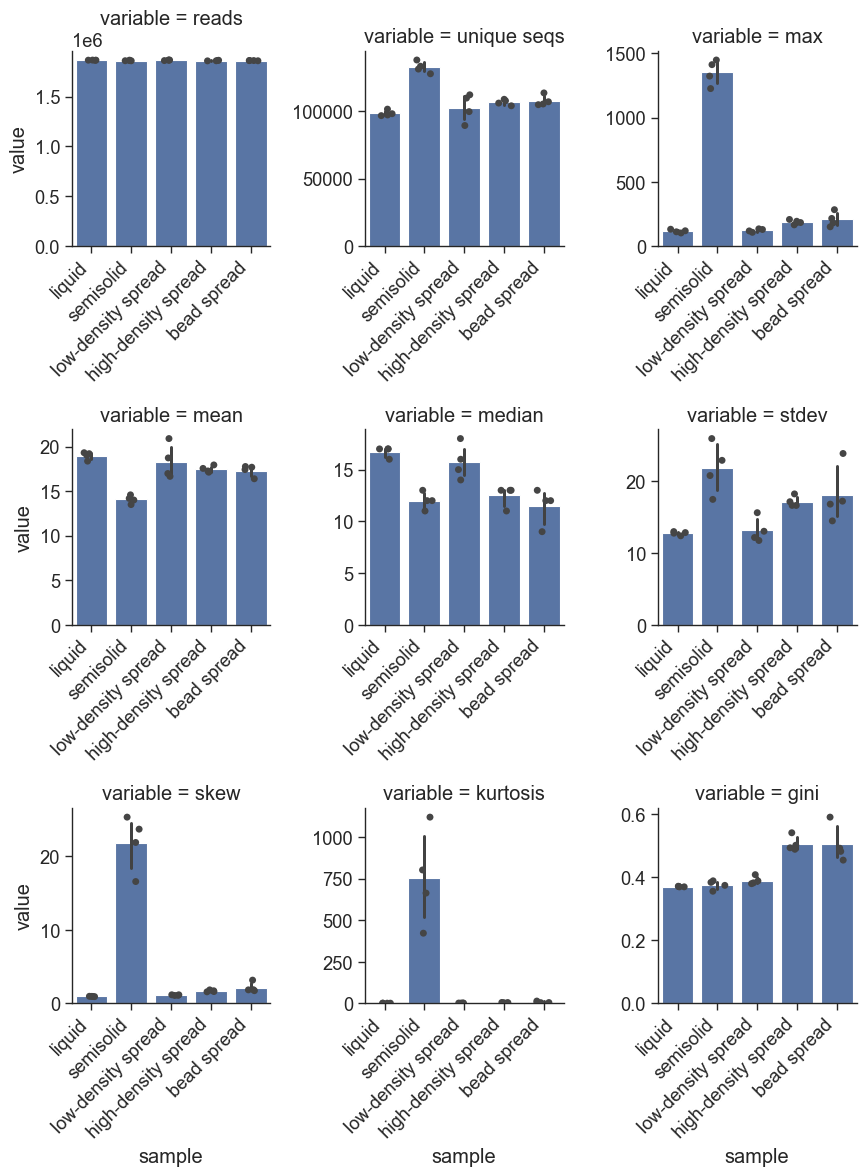

In [6]:
g = sns.FacetGrid(
    sample_stats_df, col='variable',
    col_order=['reads', 'unique seqs', 'max', 'mean', 'median', 'stdev', 'skew', 'kurtosis', 'gini'],
    col_wrap=3, height=4, aspect=0.75, sharex=False, sharey=False
)
g.map(sns.barplot, 'sample', 'value', order=sample_names)
g.map(sns.stripplot, 'sample', 'value', order=sample_names, hue_order=sample_names, color=POINT_COLOR, size=5, jitter=0.2)
for axes in g.axes.flat:
    axes.set_xticks(axes.get_xticks())
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

Compare number of unique sequences observed (Fig. 2a).

liquid vs. semisolid: Welch's t-test independent samples, P_val:6.847e-05 t=-1.429e+01
liquid vs. low-density spread: Welch's t-test independent samples, P_val:4.697e-01 t=-8.163e-01
liquid vs. high-density spread: Welch's t-test independent samples, P_val:1.579e-03 t=-5.459e+00
liquid vs. bead spread: Welch's t-test independent samples, P_val:1.146e-02 t=-4.064e+00


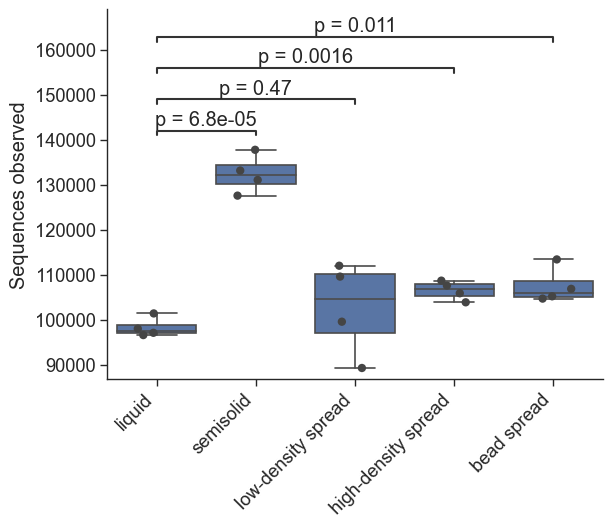

In [7]:
unique_seqs_df = sample_stats_df[sample_stats_df['variable'] == 'unique seqs']

# Plot boxplot
ax = sns.boxplot(data=unique_seqs_df, x='sample', y='value', order=sample_names, color=sns.color_palette()[0], fliersize=0)

# Add stat annotations
pairs = [('liquid', 'semisolid'), ('liquid', 'high-density spread'), ('liquid', 'low-density spread'), ('liquid', 'bead spread')]
annotator = Annotator(ax, pairs, data=unique_seqs_df, x='sample', y='value', order=sample_names)
annotator._pvalue_format.pvalue_format_string = "{:#.2g}" # Set p-value format
annotator.configure(test="t-test_welch", text_format='full', loc='inside', show_test_name=False)
annotator.apply_and_annotate()

# Plot individual points
sns.stripplot(data=unique_seqs_df, x='sample', y='value', order=sample_names, color=POINT_COLOR, size=POINT_SIZE, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Sequences observed')
plt.savefig('images/N80_count.svg', format='svg')
plt.show()

Calculate average difference in number of sequences observed between liquid and other conditions.

In [8]:
avg_counts = unique_seqs_df.groupby('sample')['value'].mean()
for sample in sample_names[1:]:
    diff = (avg_counts[sample] - avg_counts['liquid']) / avg_counts['liquid'] * 100
    print(f'{sample} vs liquid: {np.mean(diff):.2f}%')


semisolid vs liquid: 34.69%
low-density spread vs liquid: 4.41%
high-density spread vs liquid: 8.38%
bead spread vs liquid: 9.42%


Compare Gini coefficients (uniformity) of libraries (Fig. 2b).

liquid vs. semisolid: Welch's t-test independent samples, P_val:5.198e-01 t=-7.263e-01
liquid vs. low-density spread: Welch's t-test independent samples, P_val:5.751e-02 t=-2.986e+00
liquid vs. high-density spread: Welch's t-test independent samples, P_val:1.436e-03 t=-1.137e+01
liquid vs. bead spread: Welch's t-test independent samples, P_val:2.018e-02 t=-4.524e+00


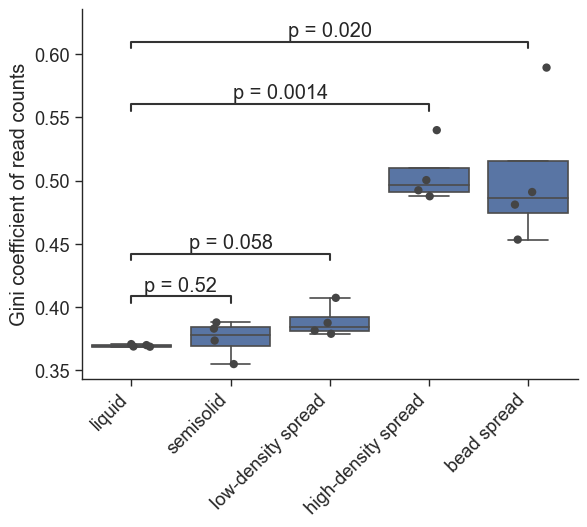

In [9]:
gini_df = sample_stats_df[sample_stats_df['variable'] == 'gini']

# Plot boxplot
ax = sns.boxplot(data=gini_df, x='sample', y='value', order=sample_names, color=sns.color_palette()[0], fliersize=0)

# Add stat annotations
pairs = [('liquid', 'semisolid'), ('liquid', 'high-density spread'), ('liquid', 'low-density spread'), ('liquid', 'bead spread')]
annotator = Annotator(ax, pairs, data=gini_df, x='sample', y='value', order=sample_names)
annotator._pvalue_format.pvalue_format_string = "{:#.2g}" # Set p-value format
annotator.configure(test="t-test_welch", text_format='full', loc='inside', show_test_name=False)
annotator.apply_and_annotate()

# Plot individual points
sns.stripplot(data=gini_df, x='sample', y='value', order=sample_names, color=POINT_COLOR, size=POINT_SIZE, jitter=0.2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Gini coefficient of read counts')
plt.savefig('images/N80_gini.svg', format='svg')
plt.show()

Plot the distribution of counts for each sample.

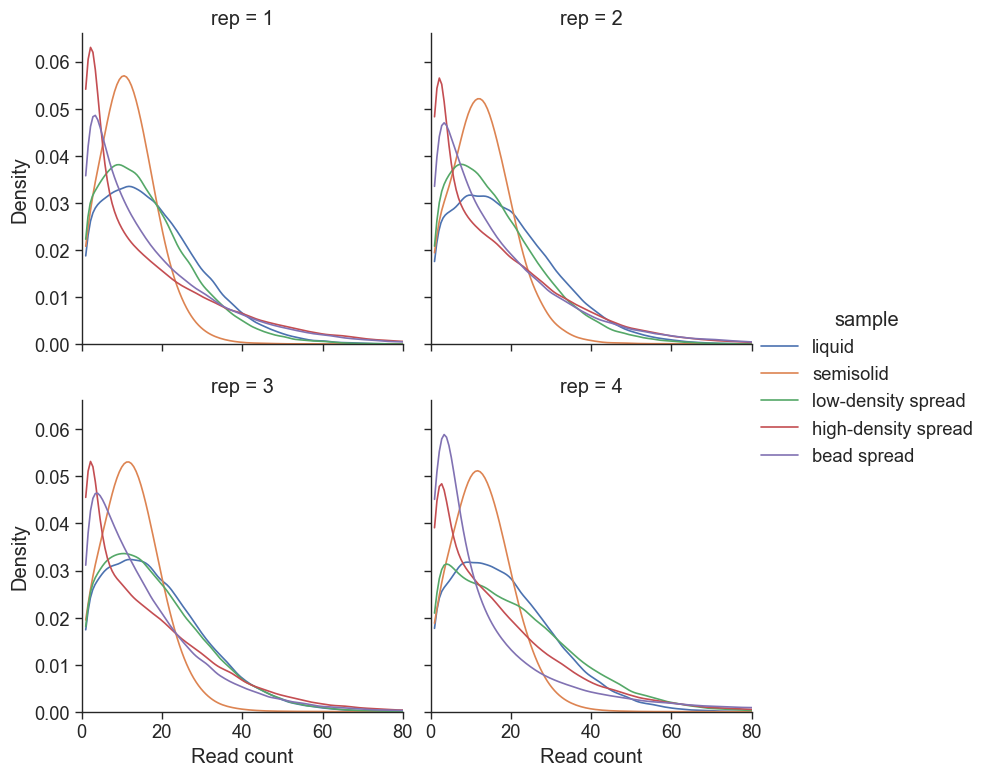

In [10]:
g = sns.FacetGrid(df, col='rep', hue='sample', col_wrap=2, height=4)
g.map(sns.kdeplot, 'count', clip=[1,120])
plt.xlim([0,80])
g.add_legend()
for axes in g.axes.flat:
    axes.set_xlabel('Read count')
plt.show()

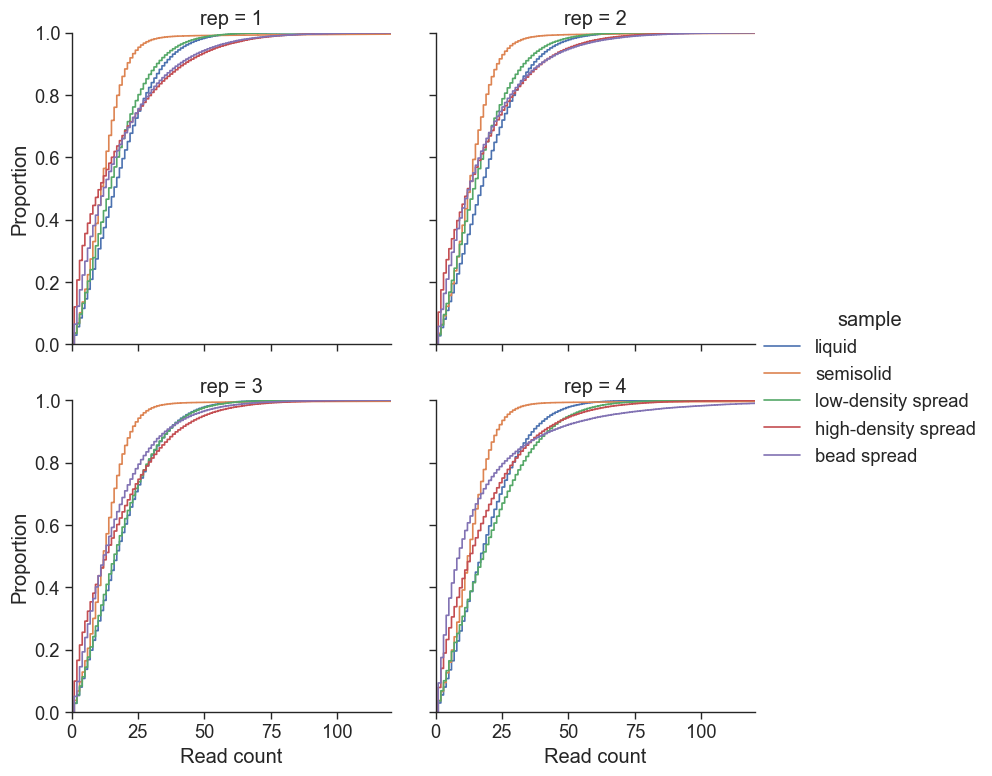

In [11]:
g = sns.FacetGrid(df, col='rep', hue='sample', col_wrap=2, height=4)
g.map(sns.ecdfplot, 'count')
plt.xlim([0,120])
g.add_legend()
for axes in g.axes.flat:
    axes.set_xlabel('Read count')
plt.show()

Plot distribution of read counts for a representative replicate (Fig. 2c).

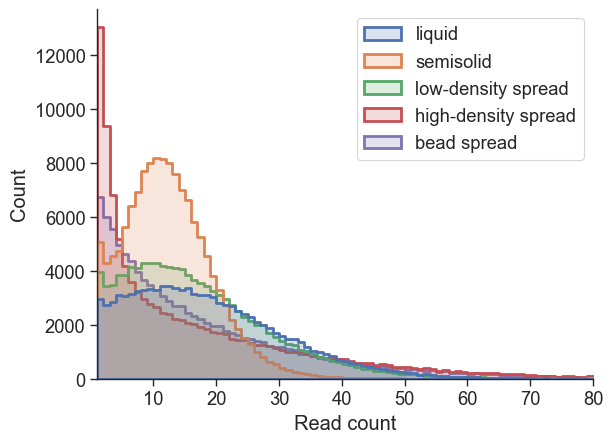

In [12]:
rep1_df = df.loc[df['rep'] == 1]
g = sns.histplot(rep1_df, x='count', hue='sample', bins=range(1, 81), element='step', alpha=0.2, linewidth=2)
plt.xlim([1,80])
g.get_legend().set_title(None)
plt.xlabel('Read count')
plt.savefig('images/N80_rep1_hist.svg', format='svg')
plt.show()

Show outliers in semisolid for a representative replicate (Fig. 2d).

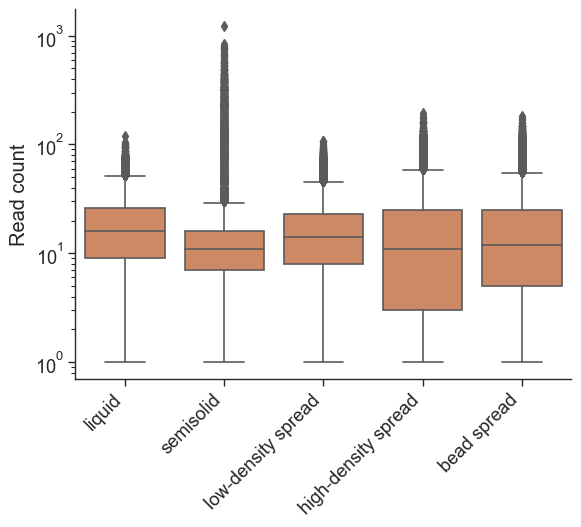

In [13]:
sns.boxplot(data=rep1_df, x='sample', y='count', color=sns.color_palette()[1])
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('Read count')
plt.savefig('images/N80_rep1_box.svg', format='svg')
plt.show()